# Image Classification




## Import Dataset From Hugging Face

Usually data is not ready

Using the MNIST dataset, I created a CNN model that recognizes handwritten digits with an accuracy of 99.64%. That is, it correctly predicted 4,972 out of 5,000 images.







In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset

# set print options to avoid scientific notation
#torch.set_printoptions(sci_mode=False)

# load the MNIST dataset
ds = load_dataset("ylecun/mnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Based on the dataset structure, we can access the images like this:

In [2]:
first_image = ds['train'][0]['image']
first_image

Please note that the images in the dataset are in PIL (Python Imaging Library) format.

In [3]:
type(first_image)

PIL.PngImagePlugin.PngImageFile

## Data Preprocessing

Usually, the collected data is not immediately ready to be the input of a machine learning model. The steps taken to clean and prepare the data are known as **data preprocessing**.

When working with PIL images in deep learning, the typical workflow involves converting them first to NumPy arrays and then, to normalized PyTorch tensors. 

Suppose we have the following 4x4 PIL image:

```{figure} ../images/image-example.png
---
width: 180px
name: image-example
---
4x4 PIL image
```

When we convert this image to a NumPy array, each pixel value ranges from 0 (black) to 255 (white), with intermediate values representing varying shades of gray.

```python
np.array([[  0,  42,  85, 127],
          [ 42,  85, 127, 170],
          [ 85, 127, 170, 213],
          [127, 170, 213, 255]])
```

Neural networks perform better when when we **normalize** the input values so that they fall within the range [0, 1]. To do this, we divide each pixel value by 255, transforming the image into a format where 0 represents black and 1 represents white.

```python
tensor([[0.0000, 0.1647, 0.3333, 0.4980],
        [0.1647, 0.3333, 0.4980, 0.6667],
        [0.3333, 0.4980, 0.6667, 0.8353],
        [0.4980, 0.6667, 0.8353, 1.0000]])
```

We will now apply these transformations to all the images in the dataset.

In [2]:
# convert PIL image to normalized PyToch tensor
def image_to_tensor(image):
    return torch.tensor(np.array(image)) / 255.0


def preprocess_data(split):
    
    x = []  # list to store image tensors
    y = []  # list to store labels

    for example in split:
        x.append(image_to_tensor(example['image']))
        y.append(example['label'])
    
    return torch.stack(x), torch.tensor(y)

train_x, train_y = preprocess_data(ds['train'])
test_x,  test_y  = preprocess_data(ds['test'])

In [5]:
train_x.shape

torch.Size([60000, 28, 28])

## Bias

As we saw in section [](1.3), a **bias** is a parameter added to the output of a neuron that enables the model to learn more complex patterns.

- The bias term allows the model to adjust the neuron's output independently of its inputs, helping the model better fit the training data and capture more complex patterns.

Bias are important for 2 main reasons:

1. **Flexibility**: Bias introduces an extra degree of freedom that enables the network to shift the activation function, making it more flexible and capable of learning a broader range of functions. Without bias, the output of a neuron is strictly dependent on the weighted sum of its inputs.

2. **Preventing Overfitting**: In some cases, bias helps avoid overfitting by allowing the network to generalize better, especially in situations where the data is not perfectly centered or the output doesn't naturally pass through the origin (zero).

In [68]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden), generator=g)   # (input_to_layer, output_from_layer)
    b1 = torch.randn(n_hidden,        generator=g)   # (output_from_layer)

    W2 = torch.randn((n_hidden, 10),  generator=g)   # (input_to_layer, output_from_layer)
    b2 = torch.randn(10,              generator=g)   # (output_from_layer)

    parameters = [W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [ ]:
max_steps = 10     # train iterations
lr = 0.1           # learning rate

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

for step in range(max_steps):
    
    # forward pass
    h1_prev = train_x.view(-1, 784) @ W1 + b1   # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h1 = torch.tanh(h1_prev)                    # non-linearity
    logits = h1 @ W2 + b2                       # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)
    probs = logits.exp() / logits.exp().sum(1, keepdims=True) # softmax
    
    # calculate loss
    loss = -probs[torch.arange(logits.shape[0]), train_y].log().mean()
    print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/10     Loss: 14.7864
Step:  1/10     Loss: 13.5648
Step:  2/10     Loss: 12.6383
Step:  3/10     Loss: 11.9046
Step:  4/10     Loss: 11.3044
Step:  5/10     Loss: 10.8029
Step:  6/10     Loss: 10.3771
Step:  7/10     Loss: 10.0094
Step:  8/10     Loss: 9.6867
Step:  9/10     Loss: 9.3992


## Intialization

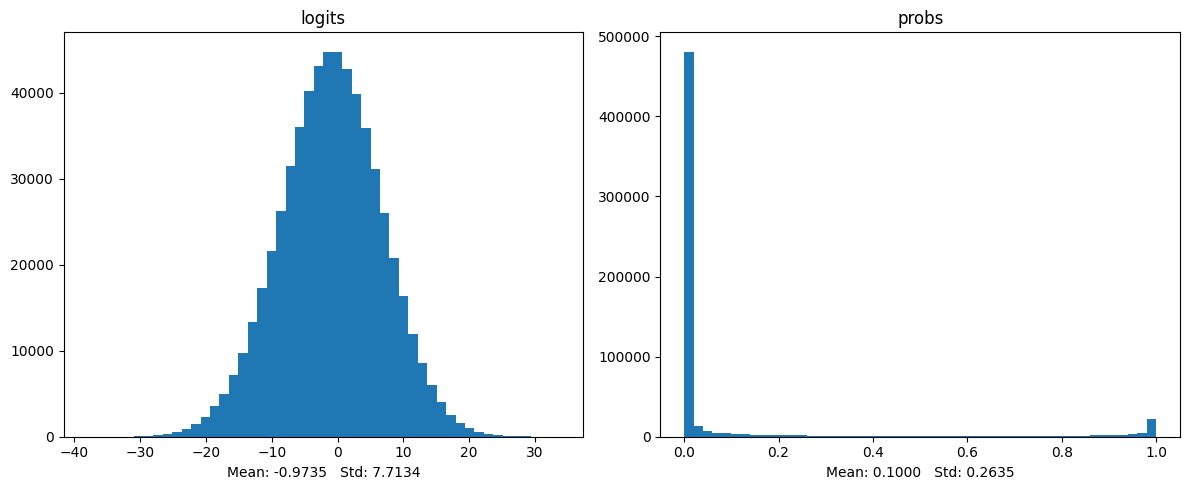

In [70]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(logits.view(-1).tolist(), 50)
plt.title('logits')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
plt.hist(probs.view(-1).tolist(), 50)
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

In [73]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,        generator=g)

    W2 = torch.randn((n_hidden, 10),  generator=g) * 0.1
    b2 = torch.randn(10,              generator=g) * 0
    
    parameters = [W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [74]:
max_steps = 10     # train iterations
lr = 0.1           # learning rate

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

for step in range(max_steps):
    
    # forward pass
    h1_prev = train_x.view(-1, 784) @ W1 + b1   # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h1 = torch.tanh(h1_prev)
    logits = h1 @ W2 + b2                       # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)

    # softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    # calculate loss
    loss = -probs[torch.arange(logits.shape[0]), train_y].log().mean()
    print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/10     Loss: 2.6487
Step:  1/10     Loss: 2.4455
Step:  2/10     Loss: 2.3133
Step:  3/10     Loss: 2.2106
Step:  4/10     Loss: 2.1241
Step:  5/10     Loss: 2.0481
Step:  6/10     Loss: 1.9797
Step:  7/10     Loss: 1.9171
Step:  8/10     Loss: 1.8595
Step:  9/10     Loss: 1.8062


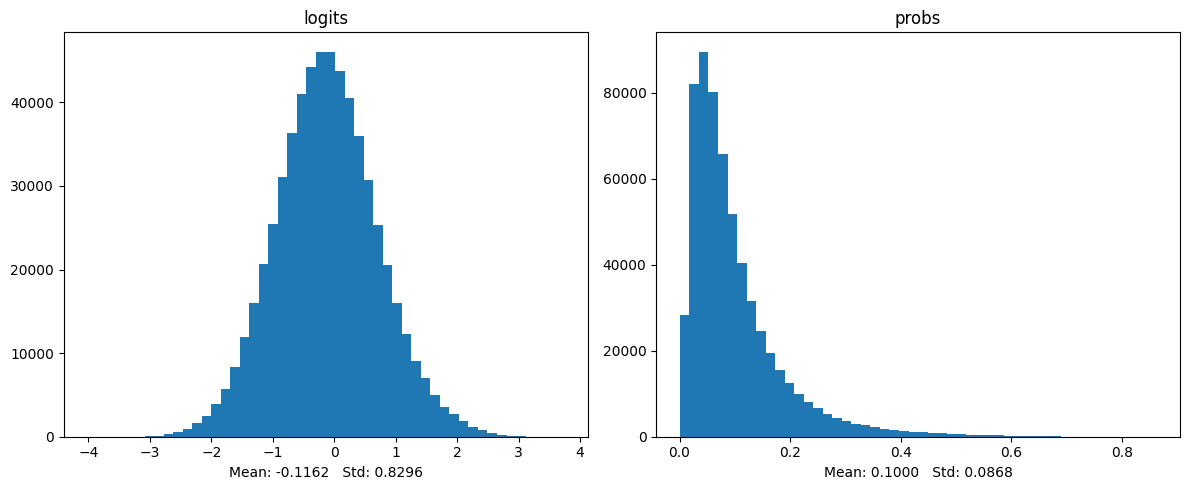

In [75]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(logits.view(-1).tolist(), 50)
plt.title('logits')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
plt.hist(probs.view(-1).tolist(), 50)
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

## Dead Neurons

Many of the 1st layer activations are either -1 or 1. This occurs because the pre-activations range between -20 and 20, leading the tanh function to saturate. As shown in the graph below, tanh squashes input values into the range [-1, 1], with large positive or negative inputs pushed closer to 1 or -1, respectively.

```{figure} ../images/tanh.png
---
width: 300px
name: tanh
---
tanh (Hyperbolic Tangent). Source: {cite}`weisstein_tanh`
```

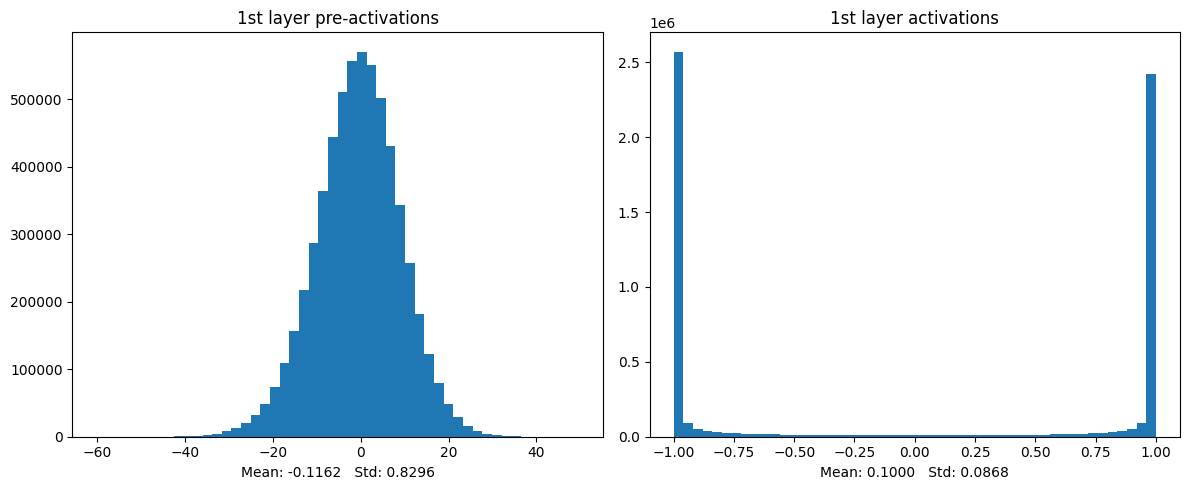

In [49]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(h1_prev.view(-1).tolist(), 50)
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
plt.hist(h1.view(-1).tolist(), 50)
plt.title('1st layer activations')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

If the activations after applying the tanh function are highly saturated (close to 1 or -1), the new gradients become close to zero during backpropagation, which slows down or even halts learning in the neural network:

$$
\text{new gradient} = (1 - \tanh^2(x)) \cdot \text{gradient}
$$

In the figure below, white pixels represent neurons that are highly saturated, effectively destroying the gradient for that example. If an entire row was white, we would have a **dead neuron**. A dead neuron is a neuron that never activates in the non-flat region of tanh and kills all gradients flowing through it, preventing learning.

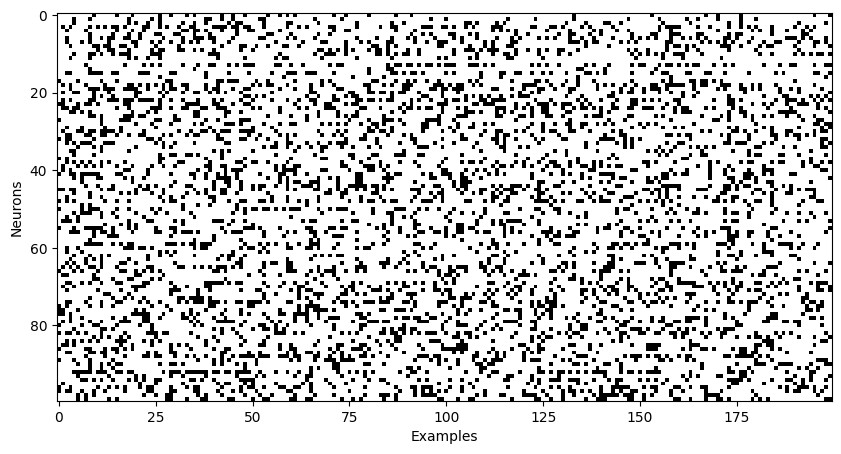

In [96]:
plt.figure(figsize=(10,8))
plt.imshow(h1[:200].T.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel("Examples")
plt.ylabel("Neurons");

<br>

## Kaiming Initialization

**Kaiming initialization** (also known as He initialization) is a method used to initialize the weights of a neural network in such a way that the gradients flow more effectively through the network. It was introduced in the paper [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852) and is particularly important when using nonlinear activation functions such as tanh or ReLU. 


The key idea behind Kaiming initialization is to prevent the activations from becoming too large or too small, which can lead to vanishing or exploding gradients as we just show. It adjusts the weights based on a scaling factor that depends on the activation function (gain) and the number of input units to a neuron (fan-in).

\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}

In [104]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden), generator=g) * (5/3)/ 784**0.5
    b1 = torch.randn(n_hidden,        generator=g)

    W2 = torch.randn((n_hidden, 10),  generator=g) * 0.1
    b2 = torch.randn(10,              generator=g) * 0
    
    parameters = [W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [ ]:
max_steps = 10     # train iterations
lr = 0.1           # learning rate

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

for step in range(max_steps):
    
    # forward pass
    h1_prev = train_x.view(-1, 784) @ W1 + b1   # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h1 = torch.tanh(h1_prev)
    logits = h1 @ W2 + b2                       # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)

    # softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    # calculate loss
    loss = -probs[torch.arange(logits.shape[0]), train_y].log().mean()
    print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/10     Loss: 2.3855


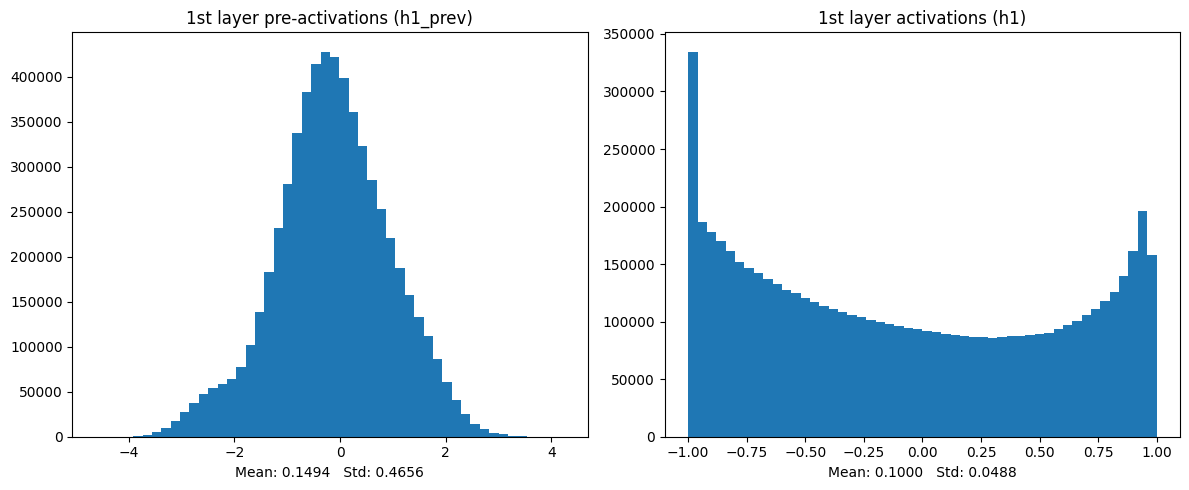

In [106]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(h1_prev.view(-1).tolist(), 50)
plt.title('1st layer pre-activations (h1_prev)')
plt.xlabel(f'Mean: {logits.mean():.4f}   Std: {logits.std():.4f}')

plt.subplot(122)
plt.hist(h1.view(-1).tolist(), 50)
plt.title('1st layer activations (h1)')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

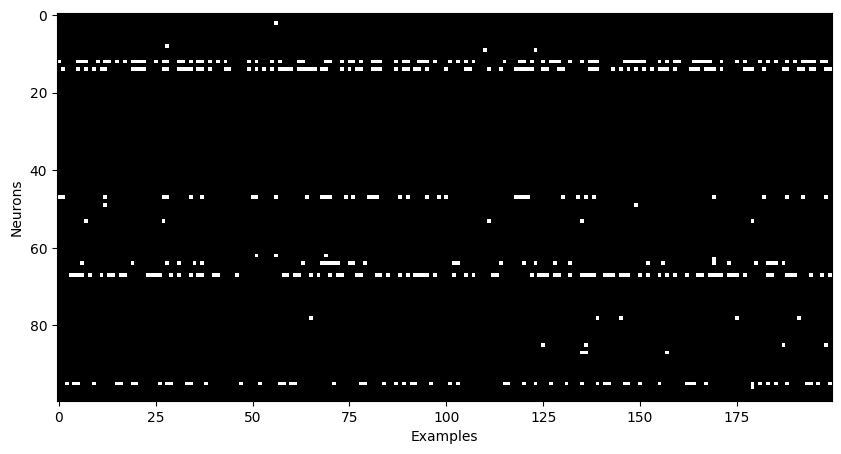

In [100]:
plt.figure(figsize=(10,8))
plt.imshow(h1[:200].T.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel("Examples")
plt.ylabel("Neurons");

<br>

## 2.5 Cross entropy

In [ ]:
max_steps = 10     # train iterations
lr = 0.1           # learning rate

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

for step in range(max_steps):
    
    # forward pass
    h1 = torch.relu(train_x.view(-1, 784) @ W1 + b1) # (60000, n_hidden) = (60000, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.relu(h1 @ W2 + b2)                    # (60000, 10) = (60000, n_hidden) x (n_hidden, 10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(h2, train_y)
    print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

<br>

(2.6)=
## 2.6 Fixing Initialization loss

In [84]:
parameters = initialize_nn()
W1, b1, W2, b2 = parameters

# forward pass
h1 = torch.relu(train_x.view(-1, 784) @ W1 + b1)
h2 = torch.relu(h1 @ W2 + b2)

# calculate loss
loss = F.cross_entropy(h2, train_y)

print(f"Intialization loss: {loss.item():.4f}")

Intialization loss: 122.4054


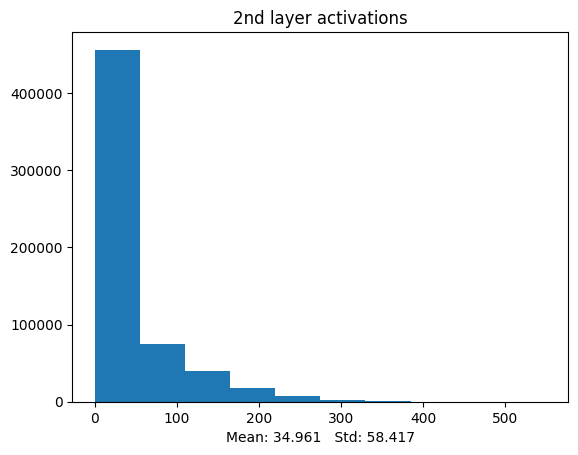

In [ ]:
plt.hist(h2.view(-1).tolist())
plt.title("2nd layer activations")
plt.xlabel(f"Mean: {h2.mean():.4f}   Std: {h2.std():.4f}");

In [103]:
def initialize_nn(n_hidden = 200):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,        generator=g)

    W2 = torch.randn((n_hidden, 10),  generator=g) * 0.1
    b2 = torch.randn(10,              generator=g) * 0

    parameters = [W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [87]:
parameters = initialize_nn()
W1, b1, W2, b2 = parameters

# forward pass
h1 = torch.relu(train_x.view(-1, 784) @ W1 + b1)
h2 = torch.relu(h1 @ W2 + b2)

# calculate loss
loss = F.cross_entropy(h2, train_y)

print(f"Intialization loss: {loss.item():.4f}")

Intialization loss: 12.3517


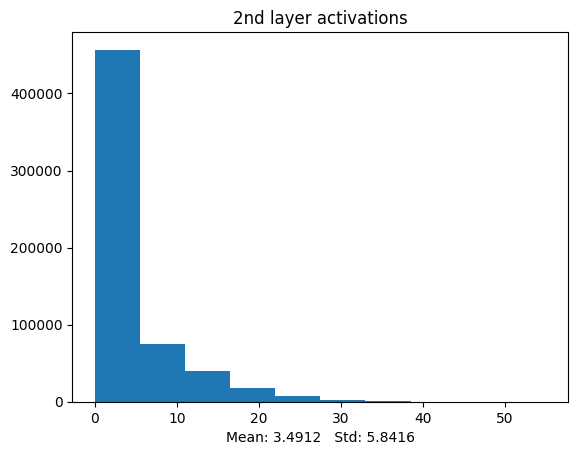

In [88]:
plt.hist(h2.view(-1).tolist())
plt.title("2nd layer activations")
plt.xlabel(f"Mean: {h2.mean():.4f}   Std: {h2.std():.4f}");

<br>

(2.5)=
## 2.5 Mini-batches

As observed, the neural network was slowly reducing the loss, and therfore learning. However,each training step took a considerable amount of time to complete because it is quite computatuonally expensive to process the entire dataset of 60,000 examples for both forward and backward passes.

To address this issue, we will use **mini-batches** (small randomly selected subsets of the dataset) rather than the entire training set in each iteration. This approach reduces computation time while still maintaining the benefits of gradient descent.

```{note}
`torch.randint(0, X.shape[0], (32,))` randomly generates 32 integers between 0 and Xtr.shape[0] that index into our dataset.
```

In [11]:
max_steps = 30      # train iterations
lr = 0.1            # learning rate
batch_size = 128    # number of examples per batch

track_log_loss = []

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

for step in range(max_steps):

    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))

    # forward pass
    h1 = torch.relu(train_x[ix].view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.relu(h1 @ W2 + b2)                        # (batch_size, 10) = (batch_size, n_hidden) x (n_hidden, 10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(h2, train_y[ix])
    track_log_loss.append(loss.log10().item())
    if step % 5 == 0 or step == max_steps - 1:
        print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/30     Loss: 39.8281
Step:  5/30     Loss: 4.3546
Step: 10/30     Loss: 2.7483
Step: 15/30     Loss: 2.4295
Step: 20/30     Loss: 2.6732
Step: 25/30     Loss: 2.6415
Step: 29/30     Loss: 2.5700


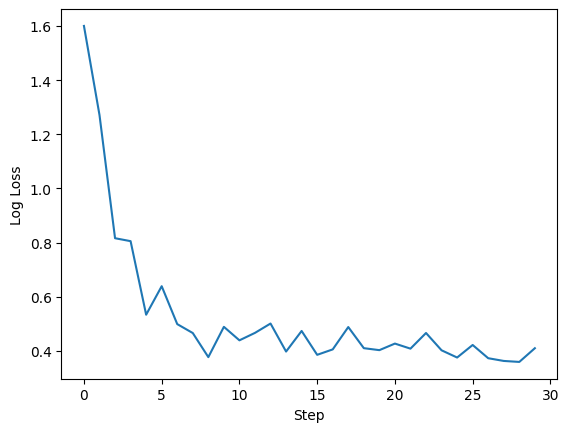

In [12]:
plt.plot(track_log_loss)
plt.xlabel('Step')
plt.ylabel('Log Loss');

This way we can run **many examples** nearly instantly and decrease the loss **much faster**. Because we are only dealing with mini-batches the quality of our gradient is lower (it is not the actual gradient direction) but the gradient direction is good enough even when it is estimating on only 32 examples. Thus, it is better to evaluate an approximate gradient, and just make more faster steps, than evaluate the exact gradient, and take fewer lower steps.

The loss we see is the loss of each batch. The loss of the whole dataset is:

In [13]:
# forward pass
h1 = torch.relu(train_x.view(-1, 784) @ W1 + b1)
h2 = torch.relu(h1 @ W2 + b2)

# calculate loss
loss = F.cross_entropy(h2, train_y)
print(f"Train Loss: {loss.item():.4f}")

Train Loss: 2.4175


## Cross Entropy

<br>

## Intialization loss

On the step 0 we got a loss of 53. Then, the loss rapidly decreased to 3. **We should expect a lower loss at initialization**.

At initialization we have no reason to believe that any number is more likely than other. Thus, initially we should expect a uniform probabilty distribution assigning about equal probability (1/10) to all the 27 characters. Hence, we should expect an **initialization loss** close to:

In [14]:
-torch.tensor(1/10).log()

tensor(2.3026)

The issue is that at initialization the **logits coming out of the neural net are not uniform** (they are extreme randomly positive or negative numbers). Some characters are very confident and some characters are very not confident so the network is very confidently wrong recording a high loss.

Intialization loss: 48.592384338378906


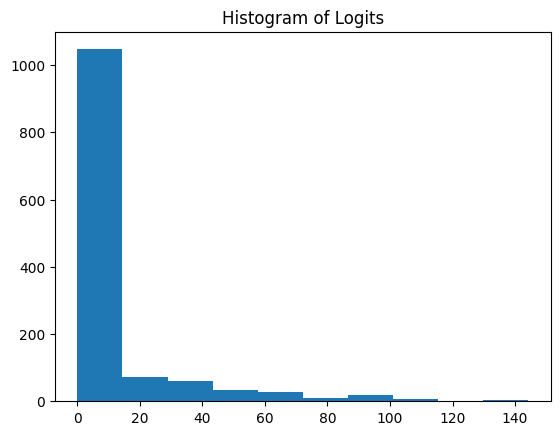

In [15]:
parameters = initialize_nn()
W1, b1, W2, b2 = parameters

# batch construct
ix = torch.randint(0, train_x.shape[0], (batch_size,))

# forward pass
h1 = torch.relu(train_x[ix].view(-1, 784) @ W1 + b1)
h2 = torch.relu(h1 @ W2 + b2)

# calculate loss
loss = F.cross_entropy(h2, train_y[ix])

print('Intialization loss:', loss.item())
plt.hist(h2.view(-1).tolist())
plt.title('Histogram of Logits');

In [16]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)    
    
    W1 = torch.randn((784, n_hidden), generator=g)   # (input_to_layer, output_from_layer)
    b1 = torch.randn(n_hidden,        generator=g)   # (output_from_layer)

    W2 = torch.randn((n_hidden, 10),  generator=g) * 0.1
    b2 = torch.randn(10,              generator=g) * 0
    
    # parameters
    parameters = [W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    return parameters

Intialization loss: 5.084749698638916


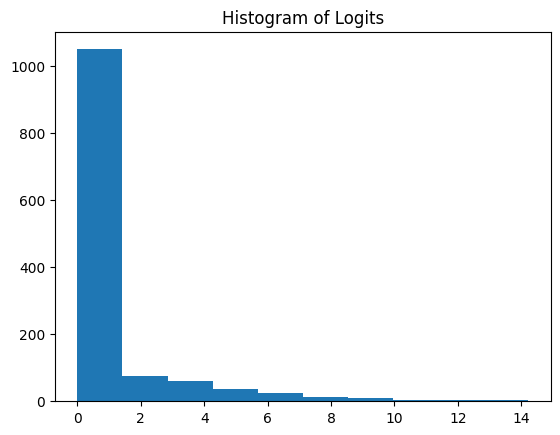

In [17]:
parameters = initialize_nn()
W1, b1, W2, b2 = parameters

# batch construct
ix = torch.randint(0, train_x.shape[0], (batch_size,))

# forward pass
h1 = torch.relu(train_x[ix].view(-1, 784) @ W1 + b1)
h2 = torch.relu(h1 @ W2 + b2)

# calculate loss
loss = F.cross_entropy(h2, train_y[ix])

print('Intialization loss:', loss.item())
plt.hist(h2.view(-1).tolist())
plt.title('Histogram of Logits');

<br>

(2.6)=
## Convolutional Neural Network

A **Convolutional Neural Network (CNN)** is a type of neural network primarly designed for tasks like image recognition and object detection.

CNNs outperform traditional neural netowrks when working with images becuase:
- They are more efficient, it is too much computation to train large-size images with different channels.
- They can capture the spatial dependencies of the image.
- They are not sensitive to the position of the object in the image.


CNNs works in two steps:
- **Feature extraction** is a phase where various filters and layers are applied to the images to extract information and features.
- **Classification** is a pahse where the image is classified based on the information extracted.


<br>

(2.7)=
## Convoultion Layer

The **convolution layer** extracts different features from the input image by applying different **filters** and producing several **feature maps**. 

```{figure} ../images/conv-layer-1.png
---
width: 340px
name: conv-layer-1
---
Convoultional Layer
```

To understand the math behind convolution layers, we will look at only one filter.

```{figure} ../images/conv-layer-2.png
---
width: 480px
name: conv-layer-2
---
Convoultional Layer 2
```

To calculate $m_{11}$, a fetaure map value, we will multiply the pixel values of the top-left 3 x 3 subregion of the input image with the filter values and add them up (sum product).

$$
m_{11} = i_{11}f_{11} + i_{12}f_{12} + i_{13}f_{13} + i_{21}f_{21} + i_{22}f_{22} + i_{23}f_{23} + i_{31}f_{31} + i_{32}f_{32} + i_{33}f_{33}
$$

To calculate $m_{12}$, we will select a 3 x 3 subregion one column to the right.

$$
m_{12} = i_{12}f_{11} + i_{13}f_{12} + i_{14}f_{13} + i_{22}f_{21} + i_{23}f_{22} + i_{24}f_{23} + i_{32}f_{31} + i_{33}f_{32} + i_{34}f_{33}
$$

The rest of the feature map values are calculated moving the 3x3 subregion similarlt. Thus, a convolution can be expressed as:
$$
m_{ij} = {f} \cdot {i}
$$

where:
- $i$ is the corresponfing subregion of the input
- $f$ is the filter

In [15]:
# seed the random number generator for reproducibility
g = torch.Generator().manual_seed(1)

# intitialize input image randomly
image = torch.randn((6,6), generator=g)


n_filters = 5
filter_size = (3,3)

# intitialize filters randomly
filters = torch.randn((n_filters, filter_size[0], filter_size[1]), generator=g)

# dimensions of the feature maps
map_size = (image.shape[0] - filter_size[0] + 1, image.shape[1] - filter_size[1] + 1)

# initialize with zeros the feature maps
maps = torch.zeros((n_filters, map_size[0], map_size[1]))

# apply convolution
for i in range(map_size[0]):

    for j in range(map_size[1]):

        # extract the subregion of the input image
        subregion = image[i:i+filter_size[0], j:j+filter_size[1]]

        # update feature map at position (i,j) for all filters
        maps[:, i, j] = filters.view(-1, 9) @ subregion.reshape(-1)

# apply ReLU activation
maps = torch.relu(maps)

maps

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.4675, 0.0000, 0.0000],
         [9.7158, 0.9713, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.4225]],

        [[2.4488, 0.9156, 4.9736, 2.1221],
         [6.5289, 5.3780, 0.3675, 2.6423],
         [0.0000, 0.0000, 0.0000, 2.3949],
         [0.0000, 0.0000, 0.4390, 0.0576]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 2.7500],
         [2.0650, 2.3081, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.3082],
         [0.0000, 2.5182, 0.0000, 0.0000],
         [7.8959, 0.0000, 0.9531, 0.0000],
         [3.7692, 0.0000, 3.1010, 0.0000]],

        [[1.0407, 0.0000, 0.0000, 0.9717],
         [0.0000, 0.0000, 0.0000, 1.6645],
         [3.6692, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

<br>


## Pooling Layer


In [16]:
pool_size = (2,2)       #  size of the pooling window

# dimensions of the feature maps after pooling
pooled_map_size = (maps.shape[1] // pool_size[0], maps.shape[2] // pool_size[1])

# initialize with zeros the pooled feature maps
pooled_maps = torch.zeros((n_filters, pooled_map_size[0], pooled_map_size[1]))

# apply max pooling
for i in range(pooled_map_size[0]):

    for j in range(pooled_map_size[1]):

        # Extract the 2x2 region for max pooling
        subregions = maps[:, 
                         i * pool_size[0]:(i+1) * pool_size[0], 
                         j * pool_size[1]:(j+1) * pool_size[1]]
        
        # Apply max pooling
        pooled_maps[:, i, j] = subregions.reshape(n_filters, -1).max(dim=1).values

pooled_maps

tensor([[[1.4675, 0.0000],
         [9.7158, 1.4225]],

        [[6.5289, 4.9736],
         [0.0000, 2.3949]],

        [[0.0000, 2.7500],
         [2.3081, 0.0000]],

        [[2.5182, 0.3082],
         [7.8959, 3.1010]],

        [[1.0407, 1.6645],
         [3.6692, 0.0000]]])

In [17]:
n_filters = 30
filter_size = (5, 5)
pool_size = (2, 2)
n_hidden = 500      # number of neurons in hidden layers


# intitialize filter, weight matrices and bias vectors randomly
g = torch.Generator().manual_seed(1)

f1 = torch.randn((n_filters, filter_size[0], filter_size[1]), generator=g)

W1 = torch.randn((4320, n_hidden), generator=g)* 0.01
b1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, 10), generator=g)* 0.01
b2 = torch.randn(10, generator=g)

# parameters
parameters = [f1, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True                     # track gradients

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

Number of parameters: 2166260


In [18]:
max_steps = 100   # train iterations
lr = 0.01         # learning rate
batch_size = 32   # number of examples per batch

track_loss = []

for step in range(max_steps):

    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))
    batch = train_x[ix]

    # apply convolution
    map_size = (batch.shape[1] - filter_size[0] + 1, batch.shape[2] - filter_size[1] + 1)
    maps = torch.zeros((batch_size, n_filters, map_size[0], map_size[1]))

    for i in range(map_size[0]):
        
        for j in range(map_size[1]):

            # extract the subregion for all images in the batch
            subregion = batch[:, i:i + filter_size[0], j:j + filter_size[1]]

            maps[:, :, i, j] = subregion.reshape(batch_size, -1) @ f1.view(-1, n_filters) # (32, 30, 24, 24) = (32, 25) @ (25, 30)
    
    maps = torch.relu(maps)
    
    # apply pool
    pooled_map_size = (maps.shape[2] // pool_size[0], maps.shape[3] // pool_size[1])
    pooled_maps = torch.zeros((batch_size, n_filters, pooled_map_size[0], pooled_map_size[1]))

    for i in range(pooled_map_size[0]):

        for j in range(pooled_map_size[1]):

            # extract the subregion for all images in the batch and filters
            subregion = maps[:, :, i * pool_size[0]:(i+1) * pool_size[0], j * pool_size[1]:(j+1) * pool_size[1]]

            pooled_maps[:, :, i, j] = subregion.reshape(batch_size, n_filters, -1).max(dim=2).values # (32, 30, 12, 12)
    
    # forward pass
    h1 = torch.relu(pooled_maps.view(batch_size, -1) @ W1 + b1) # (32, 100) = (32, 4320) x (4320, 100) + (100)
    h2 = torch.relu(h1 @ W2 + b2)                               # (32, 10) = (32, 100) x (100, 10) + (10)           

    # calculate loss
    loss = F.cross_entropy(h2, train_y[ix])
    track_loss.append(loss.item())
    if step % 3 == 0 or step == max_steps - 1:
        print(f"Step: {step:2d}/{max_steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 2.6609
Step:  3/100     Loss: 2.2325
Step:  6/100     Loss: 2.1112
Step:  9/100     Loss: 2.2291
Step: 12/100     Loss: 1.9191
Step: 15/100     Loss: 1.7430
Step: 18/100     Loss: 1.7036


KeyboardInterrupt: 

In [ ]:
-torch.tensor(1/10.0).log()

tensor(2.3026)

In [ ]:
print(f"After Convolution: {maps.mean().item()}, After ReLU: {maps.relu().mean().item()}")
print(f"After Hidden Layer 1: {h1.mean().item()}, After Hidden Layer 2: {h2.mean().item()}")


After Convolution: 0.6465530395507812, After ReLU: 0.6465530395507812
After Hidden Layer 1: 29.12189483642578, After Hidden Layer 2: 0.0


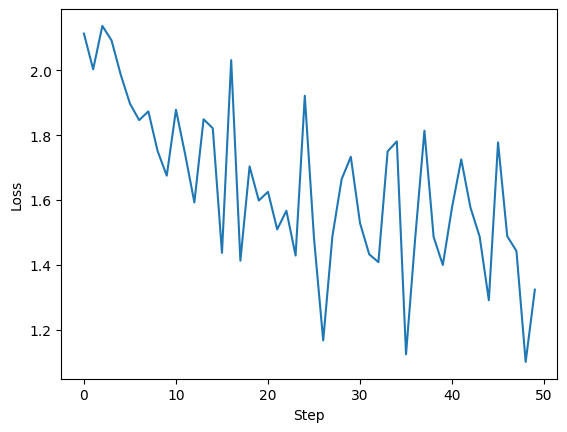

In [ ]:
plt.plot(track_loss[10:])
plt.xlabel('Step')
plt.ylabel('Loss');

<br>

(2.3)=
## 2.3 Train, Test, and Validation Splits

When working with neural networks, it is common practice to divide the dataset into three splits:

- The **train split** (80% of the dataset) is used to optimize the model parameters.
- The **validation split** (10% of the dataset) is used to optimize the hyperparameters, such as the size of the hidden layer, embedding size, and regularization strength.
- The **test split** (10% of the dataset) is used to evaluate the final performance of the model.

```{important}
The test split should be used only after the model is fully optimized, as its goal is to evaluate the model's performance on new data. Attempting to improve the test loss adjusting the hyperparameters of the model would result in overfitting.
```

In [ ]:
torch.manual_seed(2)

# shuffle the test set before splitting
indices = torch.randperm(10000)
test_x, test_y = test_x[indices], test_y[indices]

# split the test dataset into validation and test sets
val_x, test_x = test_x[:5000], test_x[5000:]
val_y, test_y = test_y[:5000], test_y[5000:]